## Inicjalizacja


In [19]:
from laptoppriceworkflow.data import get_json_data 
from laptoppriceworkflow.functions import clean_col_meta
from laptoppriceworkflow.functions import simplify_gwarancja
from laptoppriceworkflow.functions import simplify_komunikacja

import pandas as pd

import numpy as np

import seaborn as sns 

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [2]:
df = get_json_data()

# Partycjonowanie
Preprocessing przygotowania modelu bedzie przeprowadzany tylko na czesci treningowej 
Pozniej przepuszcze przez niego czesc testowa, ktora swtorzylem oraz dodtkowy plik bez zmiennej celu

In [3]:
msk = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]

In [120]:
train.head(15)

,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy
70,1599.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,nowy,500.0,sprzedawcy,"13"" - 13.9"""
1489,2999.00,grafika dedykowana,"[nfc (near field communication), gps]",1920 x 1080,2,12 gb,[windows 10 home],None,[touchpad],"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
407,2999.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,16 gb,[windows 7 professional 64-bit],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.1,intel pentium dual-core,nowy,480.0,producenta,"15"" - 15.9"""
1359,2849.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
3203,1302.91,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.5,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9"""
7831,1699.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,120.0,producenta,"15"" - 15.9"""
4586,1769.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.7,intel core i3,nowy,256.0,sprzedawcy,"15"" - 15.9"""
7524,5043.00,grafika dedykowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr3,2.6,intel core i5,nowy,1000.0,producenta,"15"" - 15.9"""
10973,6519.00,grafika dedykowana,"[bluetooth, lan 10/100/1000 mbps, lan 10/100 m...",3840 x 2160,4,16 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura podświetlana]","[kamera, głośniki, mikrofon]",ddr4,2.8,intel core i7,nowy,240.0,producenta,"15"" - 15.9"""
1510,2677.00,grafika dedykowana,"[wi-fi 802.11 a/b/g/n/ac, bluetooth, lan 10/10...",1920 x 1080,2,12 gb,[brak systemu],ssd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.4,intel core i3,nowy,240.0,producenta,"15"" - 15.9"""


# Wstępna Analiza

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5843 entries, 1359 to 5978
Data columns (total 17 columns):
buynow_price                         5843 non-null float64
rodzaj karty graficznej              5462 non-null object
komunikacja                          5249 non-null object
rozdzielczość (piksele)              5369 non-null object
liczba rdzeni procesora              5843 non-null object
wielkość pamięci ram                 5494 non-null object
system operacyjny                    5338 non-null object
typ dysku twardego                   5507 non-null object
sterowanie                           5321 non-null object
multimedia                           5304 non-null object
typ pamięci ram                      5183 non-null object
taktowanie bazowe procesora (ghz)    5135 non-null float64
seria procesora                      5431 non-null object
stan                                 5843 non-null object
pojemność dysku (gb)                 5466 non-null float64
gwarancja        

In [6]:
train.isnull().sum()/train.shape[0]

buynow_price                         0.000000
rodzaj karty graficznej              0.065206
komunikacja                          0.101660
rozdzielczość (piksele)              0.081123
liczba rdzeni procesora              0.000000
wielkość pamięci ram                 0.059730
system operacyjny                    0.086428
typ dysku twardego                   0.057505
sterowanie                           0.089338
multimedia                           0.092247
typ pamięci ram                      0.112956
taktowanie bazowe procesora (ghz)    0.121171
seria procesora                      0.070512
stan                                 0.000000
pojemność dysku (gb)                 0.064522
gwarancja                            0.000000
wielkość matrycy                     0.047065
dtype: float64

In [28]:
# Funkcja sprawdzajaca liczbe kategorii w kolumnie

for col_name in train.columns:
    if train[col_name].dtypes == 'object':
        unique_cat = len(train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories" .format(
            col_name =col_name, unique_cat = unique_cat))

Feature 'rodzaj karty graficznej' has 3 unique categories


TypeError: unhashable type: 'list'

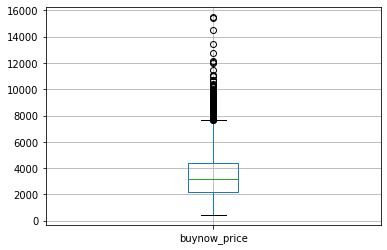

In [7]:
train.boxplot("buynow_price")

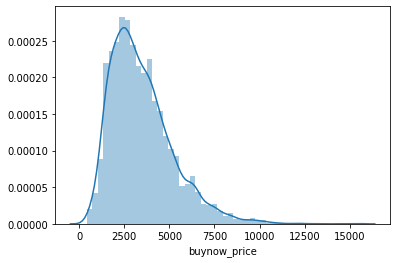

In [8]:
sns.distplot(train["buynow_price"])
plt.show()

# Budowa Preprocesingu

In [72]:
train_num = train[['taktowanie bazowe procesora (ghz)', 'pojemność dysku (gb)', 'wielkość pamięci ram']]

In [137]:
train[['taktowanie bazowe procesora (ghz)', 'pojemność dysku (gb)', 'wielkość pamięci ram']].head(15)

,taktowanie bazowe procesora (ghz),pojemność dysku (gb),wielkość pamięci ram
70,1.9,500.0,8 gb
1489,2.0,480.0,12 gb
407,2.1,480.0,16 gb
1359,2.0,480.0,8 gb
3203,1.5,128.0,8 gb
7831,1.6,120.0,4 gb
4586,1.7,256.0,8 gb
7524,2.6,1000.0,8 gb
10973,2.8,240.0,16 gb
1510,2.4,240.0,12 gb


imputer = SimpleImputer(strategy = 'median')
imputer.fit(df_num)
imputer.statistics_

X = imputer.transform(df_num)
df_num_imp = pd.DataFrame(X, columns=df_num.columns)


encoder = LabelEncoder()
#df_cat = df[["rodzaj karty graficznej", "komunikacja","rozdzielczość (piksele)"]]
df_cat = df["liczba rdzeni procesora"]
df_cat_encoded = encoder.fit_transform(df_cat)
df_cat_encoded

Lepsze gdy w kolumnie masz bardzo dużo kategorii i powstaje macierz rzadka (sparse matrix)
W innym przypadku lepiej LabelBinarizer() :)

In [115]:
#rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

#buynow_price_ix, taktowanie_bazowe_procesora_ghz_ix, pojemność_dysku_gb_ix = 0, 1, 2
wielkosc_pamieci_ram_ix = 2

class CombinedAttributesAdder_num(BaseEstimator, TransformerMixin):
    
    def __init__(self, wielkosc_pamiec_ram = True): # żadnych zmiennych *args ani **kargs
        self._wielkosc_pamiec_ram = wielkosc_pamiec_ram
    
    def fit(self, X, y=None):
        return self # nie robi nic innego
    
    def transform(self, X, y=None):
        if self._wielkosc_pamiec_ram:
            wielkosc_pamieci_ram_trans = [0 if "mb" in x else int(x.strip('gb')) for x in X[:, wielkosc_pamieci_ram_ix]]

            return np.c_[X, wielkosc_pamieci_ram_trans]
        else:
            return X

In [171]:
attr_adder = CombinedAttributesAdder(add_price_per_gb=True)
df_extra_attribs = attr_adder.transform(df.values)

In [111]:
gwarancja_ix = 0
rozdzielczosc_ix = 3
liczba_rdzeni_proc_ix = 4
#wielkosc_pamieci_ram_ix = 5
seria_procesora_ix = 5

class CombinedAttributesAdder_cat(BaseEstimator, TransformerMixin):
                 
    def __init__(self, trans_gwarancja = True):
        self._trans_gwrancja = trans_gwarancja
    
    def fit(self, X, y = None):
        return self # nie robi nic innego
    
    def transform(self, X, y = None):
        if self._trans_gwrancja:
            gwarancja_trans = ['producenta' if x == 'producenta' else 'other' for x in X[:, gwarancja_ix]]
            rozdzielczosc_trans = ['1920 x 1080' if x == '1920 x 1080' else '1366 x 768' if x == '1366 x 768' else 'other' for x in X[:, rozdzielczosc_ix]]
            liczba_rdzeni_proc_trans = ['2' if x == '2' else 'other' for x in X[:, liczba_rdzeni_proc_ix]]
            #wielkosc_pamieci_ram_trans = [0 if "mb" in x else int(x.strip('gb')) for x in X[:, wielkosc_pamieci_ram_ix]]
            seria_procesora_trans = ['intel core i7' if x == 'intel core i7 ' else 'intel core i5' if x == 'intel core i5' else 'intel core i3' if x == 'intel core i3' else 'other' for x in X[:,seria_procesora_ix]]
            
            X = np.delete(X, np.s_[gwarancja_ix, rozdzielczosc_ix, liczba_rdzeni_proc_ix, seria_procesora_ix], 1)
                    
            return np.c_[np.asarray(gwarancja_trans).reshape(-1,1), rozdzielczosc_trans, liczba_rdzeni_proc_trans, seria_procesora_trans, X]
        else:
            return X

In [112]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [163]:
cat_attribs = list(["gwarancja", "typ dysku twardego","rodzaj karty graficznej", "rozdzielczość (piksele)", "liczba rdzeni procesora", 'seria procesora'])
num_attribs = list(train_num)

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('imputerr', SimpleImputer(missing_values=None, strategy="most_frequent")),
    ('attribs_adder_cat',CombinedAttributesAdder_cat()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="mean")),
    #('imputer', SimpleImputer(strategy="constant", fill_value=None)),
    #('attribs_adder_num', CombinedAttributesAdder_num()),
    #('std_scaler', StandardScaler()),
    ])

In [164]:
tt = num_pipeline.fit_transform(train)
#ttt = cat_pipeline.fit_transform(train)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: '8 gb'

In [165]:
tt

array([[1.9, 500.0, '8 gb'],
       [2.0, 480.0, '12 gb'],
       [2.1, 480.0, '16 gb'],
       ...,
       ['missing_value', 32.0, None],
       [2.3, 128.0, '4 gb'],
       [2.4, 128.0, '8 gb']], dtype=object)

In [93]:
full_pipeline = FeatureUnion(transformer_list=[
    ("cat_pipeline", cat_pipeline),
    ("num_pipeline", num_pipeline),
])

In [94]:
housing_prepared = full_pipeline.fit_transform(train)
housing_prepared[0:6]

TypeError: '<' not supported between instances of 'str' and 'NoneType'

In [55]:
#pd.DataFrame(df_extra_attribs, columns=df_num.columns)
#train_labels = pd.DataFrame(housing_prepared, columns = df_num.columns.append(pd.Index(['price_per_ghz','4242'])))


,buynow_price,taktowanie bazowe procesora (ghz),pojemność dysku (gb),price_per_ghz,4242
0,1599.0,1.9,500.0,0.001188,0.312695
1,2999.0,2.0,480.0,0.000667,0.160053
2,2999.0,2.1,480.0,0.000700,0.160053
3,2849.0,2.0,480.0,0.000702,0.168480
4,2319.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
7848,1329.0,1.6,128.0,0.001204,0.096313
7849,979.0,NaN,32.0,NaN,0.032686
7850,2565.0,2.3,128.0,0.000897,0.049903
7851,4079.0,2.5,1128.0,0.000613,0.276538


In [17]:
train_labels = train['buynow_price'].copy()
test_labels = test['buynow_price'].copy()


In [13]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
some_data = test
some_labels = test_labels

some_data_prepared = full_pipeline.transform(some_data)
print("Prognozy:", lin_reg.predict(some_data_prepared))
print("Etykiety:", list(some_labels))

ValueError: Found unknown categories [24] in column 3 during transform

In [59]:
price_predictions = lin_reg.predict(some_data_prepared)
lin_mse = mean_squared_error(test_labels[:300], price_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1187.543385313564

In [69]:
test['wielkość pamięci ram'].value_counts()

8 gb     775
4 gb     439
16 gb    275
12 gb    202
32 gb     76
6 gb      37
2 gb      22
20 gb     19
64 gb      2
24 gb      1
Name: wielkość pamięci ram, dtype: int64

In [70]:
train['wielkość pamięci ram'].value_counts()

8 gb      2359
4 gb      1290
16 gb      781
12 gb      597
32 gb      271
2 gb       105
6 gb        95
20 gb       53
64 gb        3
256 mb       1
Name: wielkość pamięci ram, dtype: int64

In [5]:
train = clean_col_meta(train)

In [11]:
df["lan 10/100 mbps"] = (df["komunikacja"].str.contains('lan 10/100 mbps', regex=False)*1).sum()

In [12]:
df["lan 10/100/1000 mbps"] = (df["komunikacja"].str.contains('lan 10/100/1000 mbps', regex=False)*1).sum()

In [13]:
(df["komunikacja"].str.contains('nfc (near field communication)', regex=False)*1).sum()

1454

In [14]:
(df["komunikacja"].str.contains('modem 3g (wwan)', regex=False)*1).sum()

1009

In [15]:
(df["komunikacja"].str.contains('gps', regex=False)*1).sum()

269

In [16]:
(df["komunikacja"].str.contains('intel wireless display (widi)', regex=False)*1).sum()

1004

In [17]:
(df["komunikacja"].str.contains('modem 4g (lte)', regex=False)*1).sum()

267

In [18]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n', regex=False)*1).sum()

73

In [19]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n/ac', regex=False)*1).sum()

166

In [20]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n/ac', regex=False)*1).sum()

143

In [21]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n', regex=False)*1).sum()

17

In [22]:
df.shape

(7853, 20)

In [23]:
160/7853

0.020374379218133197

In [24]:
df.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
       'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'],
      dtype='object')

In [25]:
df.index

Int64Index([   70,  1489,   407,  1359, 10567,  3203,  7831,  4586,  7524,
            10973,
            ...
             6423,  7596, 11321, 11695,  6406, 10541,  8281,  8053,  8727,
             5978],
           dtype='int64', length=7853)

In [26]:
assert all(df.columns == ['buynow_price', 'rodzaj karty graficznej', 'komunikacja','rozdzielczość (piksele)', 'liczba rdzeni procesora',
        'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
        'sterowanie', 'multimedia', 'typ pamięci ram',
        'taktowanie bazowe procesora (ghz)', 'seria procesora',
        'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
        'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'])